# Estudo da Doença de Parkinson

## Uma abordagem de aprendizado de máquinas para o estudo Parkinson’s Progression Markers Initiative (PPMI)

### Aluno: Francisco Malaguth

2º semestre de 2018

## Introdução

O diagnóstico prévio de uma doença é um aspecto importante para o seu tratamento. Assim, investimentos em técnicas e tecnologias para antecipar o diagnóstico são comuns em doenças com alta ocorrência e que não possuem um tratamento efetivo. Por isso, a doença de Parkinson é uma boa opção para este estudo, uma vez que, é a segunda doença cognitiva degenerativa mais comum.

Em primeiro lugar, temos atualmente uma sobrecarga de dados médicos. A análise dessa quantidade massiva de dados está além das capacidades humanas, necessitando de novas técnicas para sua avaliação e a abordagem de aprendizado de máquina é perfeita para essa situação com grandes conjuntos de dados. No caso do diagnóstico da doença de Parkinson, um distúrbio cujos sintomas se manifestam lentamente, podemos utilizar dados obtidos para estudar os efeitos em um espaço longitudinal, por exemplo, para treinar um algoritmo com o objetivo de diagnosticar a doença com base no desenvolvimento dos sintomas e suas características.

A doença de Parkinson não tem cura, apenas tratamento para aliviar os sintomas. Portanto, diagnosticar rapidamente a doença é essencial para iniciar o tratamento precocemente, quando a doença e seus sintomas não se desenvolveram em um estágio grave.

Em busca de mais conhecimento sobre uma doença é comum utlizarmos de diferentes abordagens para pesquisar ou examinar diversos tipos de dados e indicadores. Essas diferentes abordagens em diferentes tipos de dados são a base para o uso de múltiplos indicadores como potenciais evidências para o diagnóstico da doença de Parkinson. Diferentes algoritmos de aprendizado de máquina serão treinados utilizando os dados obtidos pelo estudo do PPMI, buscando novas correlações entre a doença e esses tipos de dados, na tentativa de identificar as principais características para o treinamento dos algoritmos que também apontam possíveis indicadores para causas, sintomas e sinais da doença.

Como objetivo deste trabalho, temos a identificação de características relevantes para o diagnóstico da doença de Parkinson e a possível distinção de outros parkinsonismos a partir de dados distintos. Essas características não têm viés de algoritmos de aprendizado de máquina, pois diferentes algoritmos são usados para treinar e testar os modelos, encontrando as características mais relevantes.

## Objetivo Principal

Identificar os biomarcadores mais relevantes para diagnóstico da doença de Parkinson e parkinsonismos de forma a predizer o desenvolvimento da doença.

## Metodologia

### Tratamento de dados

O conjunto de dados utilizado foi o disponibilizado no estudo \textit{Parkinson's Progression Markers Initiative} (PPMI).
      
Nesse conjunto temos dados semi-estruturados que foram tratados de forma a construir um banco de dados relacional (SQLite) para facilitar a visualização dos dados e decisão de quais colunas utilizar. Para isso foi utilizado um algoritmo pronto cujo código está disponível no [Github](https://github.com/Malaguth/ppmi)

### Desenvolvimento

Após o processamento, os dados são separados em grupos, sendo eles:
Características demográficas;
Características motoras;
Características não motoras;
Espécime biológicos;
Neuro imagem;
Medicamentos.
    
A manifestação dos sintomas de cada grupo ocorre em diferentes épocas do desenvolvimento da doença, dessa forma a relevância dos biomarcadores é dada pelo seu impacto na classificação da doença em relação ao período em que ela se manifesta.
    
Com objetivo de identificar o estágio da doença é utilizado o algoritmo Gaussian Mixture Model (GMM) de forma a classificar de forma não supervisionada os dados dos pacientes com diagnóstico positivo.
    
Na sequência é realizada a classificação supervisionada do resultado da GMM agrupado aos demais dados a partir de diferentes classificadores com objetivo de determinar os biomarcadores mais relevantes. Para identificar o impacto desses indicadores nos algoritmos utilizamos o SHapley Additive exPlanations (SHAP) e avaliamos o resultado a partir do Receiver Operating Characteristic (ROC).

## Conclusão

Após estudo dos resultados foi possível identificar que os indicadores que sofrem maior anomalia são os indicadores de avaliação, principalmente os motores.

Além disso podemos observar que classificar um indivíduo com parkinson é uma tarefa simples, porém prever a progressão da doença não é trivial. 

In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import shap

from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

from sklearn import metrics, decomposition, mixture
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier

%matplotlib inline

In [243]:
shap.initjs()

## Representação intermediária

As tabelas de interesse de cada arquivo CSV presente na base de dados foi selecionada adicionada a um arquivo de representação intermediária (IR) que é utilizado para realizar o filtro das dados. A construção da IR pode ser visto no notebook [Filtro de Dados](Filtro.ipynb).

In [244]:
with open('../ir/data_ppmi.pkl', 'rb') as f:
    data = pkl.load(f)

## Leitura e processamento de dados

Utilizando as tabelas da IR é utilizada para filtras as colunas dos arquivos CSVs e além dissão são realizadas algumas operações para discriminação dos dados.

## Dados de espécime biológico

In [245]:
biospecimen = pd.read_csv("../../data/Biospecimen/Pilot_Biospecimen_Analysis_Results.csv", index_col=["PATNO"])

biospecimen["CLINICAL_EVENT"].replace([
    'Baseline Collection',
    'Screening Visit',
    'Visit 01',
    'Visit 02',
    'Visit 03',
    'Visit 04',
    'Visit 05',
    'Visit 06',
    'Visit 07',
    'Visit 08',
    'Visit 09',
    'Visit 10',
    'Visit 11',
    'Visit 12'],
    ['BL',
     'SC',
     'V01',
     'V02',
     'V03',
     'V04',
     'V05',
     'V06',
     'V07',
     'V08',
     'V09',
     'V10',
     'V11',
     'V12'],
    inplace=True)

biospecimen.rename(columns={'CLINICAL_EVENT':'EVENT_ID'}, inplace=True)
csf = biospecimen[(biospecimen["TYPE"] == 'Cerebrospinal fluid') & ~(biospecimen["TESTVALUE"] == "below detection limit")][["EVENT_ID", "TESTNAME", "TESTVALUE"]]
hemoglobin = csf[csf["TESTNAME"] == "CSF Hemoglobin"].reset_index().drop_duplicates(["PATNO","EVENT_ID","TESTNAME"]).set_index(['PATNO', 'EVENT_ID'])
alpha_syn = csf[csf["TESTNAME"] == "CSF Alpha-synuclein"].reset_index().drop_duplicates(["PATNO","EVENT_ID","TESTNAME"]).set_index(['PATNO', 'EVENT_ID'])
total_tau = csf[csf["TESTNAME"] == "Total tau"].reset_index().drop_duplicates(["PATNO","EVENT_ID","TESTNAME"]).set_index(['PATNO', 'EVENT_ID'])
abeta_42 = csf[csf["TESTNAME"] == "Abeta 42"].reset_index().drop_duplicates(["PATNO","EVENT_ID","TESTNAME"]).set_index(['PATNO', 'EVENT_ID'])
p_tau181p = csf[csf["TESTNAME"] == "p-Tau181P"].reset_index().drop_duplicates(["PATNO","EVENT_ID","TESTNAME"]).set_index(['PATNO', 'EVENT_ID'])
dna = biospecimen[(biospecimen["TYPE"] == 'DNA')][["EVENT_ID", "TESTNAME", "TESTVALUE"]]
rna = biospecimen[(biospecimen["TYPE"] == 'RNA')][["EVENT_ID", "TESTNAME", "TESTVALUE"]]
plasma = biospecimen[(biospecimen["TYPE"] == 'Plasma')][["EVENT_ID", "TESTNAME", "TESTVALUE"]]
serum = biospecimen[(biospecimen["TYPE"] == 'Serum')][["EVENT_ID", "TESTNAME", "TESTVALUE"]]

## Dados médicos

In [246]:
pd_start = pd.read_csv("../../data/Medical_History/PD_Features.csv", index_col=["PATNO"], usecols=data["pd_features"])

In [247]:
pd_medication = pd.read_csv("../../data/Medical_History/Use_of_PD_Medication.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["pd_medication"])

In [248]:
vital_signs = pd.read_csv("../../data/Medical_History/Vital_Signs.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["vital_sign"])

## Dados de exames neurológicos

In [249]:
neuro_cranial = pd.read_csv("../../data/Medical_History/Neurological_Exam_-_Cranial_Nerves.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["neuro_cranial"])

## Dados de avaliação motora

In [250]:
updrs1 = pd.read_csv("../../data/Motor___MDS-UPDRS/MDS_UPDRS_Part_I.csv", index_col=["PATNO", "EVENT_ID"], parse_dates=["INFODT"], usecols=data["updrs1"])

In [251]:
updrs1pq = pd.read_csv("../../data/Motor___MDS-UPDRS/MDS_UPDRS_Part_I__Patient_Questionnaire.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["updrs1pq"])

In [252]:
updrs2pq = pd.read_csv("../../data/Motor___MDS-UPDRS/MDS_UPDRS_Part_II__Patient_Questionnaire.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["updrs2pq"])

In [253]:
updrs3_temp = pd.read_csv("../../data/Motor___MDS-UPDRS/MDS_UPDRS_Part_III.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["updrs3_temp"])
updrs3 = updrs3_temp[updrs3_temp.PAG_NAME == 'NUPDRS3']
updrs3a = updrs3_temp[updrs3_temp.PAG_NAME == 'NUPDRS3A']

In [254]:
updrs4 = pd.read_csv("../../data/Motor___MDS-UPDRS/MDS_UPDRS_Part_IV.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["updrs4"])

In [255]:
schwab = pd.read_csv("../../data/Motor___MDS-UPDRS/Modified_Schwab_+_England_ADL.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["schwab"])

In [256]:
pase_house = pd.read_csv("../../data/Motor___MDS-UPDRS/PASE_-_Household_Activity.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["pase_house"])

## Dados de avaliação não motora

In [257]:
benton = pd.read_csv("../../data/Non-motor_Assessments/Benton_Judgment_of_Line_Orientation.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["benton"])

In [258]:
cog_catg = pd.read_csv("../../data/Non-motor_Assessments/Cognitive_Categorization.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["cog_catg"])

In [259]:
epworth = pd.read_csv("../../data/Non-motor_Assessments/Epworth_Sleepiness_Scale.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["epworth"])

In [260]:
geriatric = pd.read_csv("../../data/Non-motor_Assessments/Geriatric_Depression_Scale__Short_.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["geriatric"])
geriatric["total_pos"] = geriatric[data["geriatric_pos"]].sum(axis=1)
geriatric["total_neg"] = geriatric[data["geriatric_neg"]].sum(axis=1)
geriatric = geriatric["total_pos"] + 5 - geriatric["total_neg"]

In [261]:
hopkins_verbal = pd.read_csv("../../data/Non-motor_Assessments/Hopkins_Verbal_Learning_Test.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["hopkins_verbal"])

In [262]:
letter_seq = pd.read_csv("../../data/Non-motor_Assessments/Letter_-_Number_Sequencing__PD_.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["letter_seq"])

In [263]:
moca = pd.read_csv("../../data/Non-motor_Assessments/Montreal_Cognitive_Assessment__MoCA_.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["moca"])
moca["visuospatial"]   = moca[data["moca_visuospatial"]].sum(axis=1)
moca["naming"]         = moca[data["moca_naming"]].sum(axis=1)
moca["attention"]      = moca[data["moca_attention"]].sum(axis=1)
moca["language"]       = moca[data["moca_language"]].sum(axis=1)
moca["delayed_recall"] = moca[data["moca_delayed_recall"]].sum(axis=1)
moca                   = moca[["visuospatial", "naming", "attention", "language", "delayed_recall", "MCAABSTR", "MCAVFNUM", "MCATOT"]]

In [264]:
upsit = pd.read_csv("../../data/Non-motor_Assessments/Olfactory_UPSIT.csv", index_col=["SUBJECT_ID"], usecols=data["upsit"])

In [265]:
quip = pd.read_csv("../../data/Non-motor_Assessments/QUIP_Current_Short.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["quip"])

In [266]:
rem = pd.read_csv("../../data/Non-motor_Assessments/REM_Sleep_Disorder_Questionnaire.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["rem"])

In [267]:
aut = pd.read_csv("../../data/Non-motor_Assessments/SCOPA-AUT.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["aut"])
aut["gastrointestinal_up"]   = aut[data["aut_gastrointestinal_up"]].sum(axis=1)
aut["gastrointestinal_down"] = aut[data["aut_gastrointestinal_down"]].sum(axis=1)
aut["urinary"]               = aut[data["aut_urinary"]].sum(axis=1)
aut["cardiovascular"]        = aut[data["aut_cardiovascular"]].sum(axis=1)
aut["thermoregulatory"]      = aut[data["aut_thermoregulatory"]].sum(axis=1)
aut["pupillomotor"]          = aut[data["aut_pupillomotor"]].sum(axis=1)
aut["skin"]                  = aut[data["aut_skin"]].sum(axis=1)
aut["sexual"]                = aut[data["aut_sexual"]].sum(axis=1)
aut                          = aut[["gastrointestinal_up", "gastrointestinal_down", "urinary", "cardiovascular", "thermoregulatory", "pupillomotor", "skin", "sexual"]]

In [268]:
semantic = pd.read_csv("../../data/Non-motor_Assessments/Semantic_Fluency.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["semantic"])

In [269]:
stai = pd.read_csv("../../data/Non-motor_Assessments/State-Trait_Anxiety_Inventory.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["stai"])
stai["a_state"] = stai[data["stai_a_state_pos"]].sum(axis=1) + (5 * len(data["stai_a_state_neg"]) - stai[data["stai_a_state_neg"]].sum(axis=1))
stai["a_trait"] = stai[data["stai_a_trait_pos"]].sum(axis=1) + (5 * len(data["stai_a_trait_neg"]) - stai[data["stai_a_trait_neg"]].sum(axis=1))
stai = stai[["a_state", "a_trait"]]

In [270]:
sdm = pd.read_csv("../../data/Non-motor_Assessments/Symbol_Digit_Modalities.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["sdm"])

In [271]:
upsit_booklet = pd.read_csv("../../data/Non-motor_Assessments/University_of_Pennsylvania_Smell_ID_Test.csv", index_col=["PATNO", "EVENT_ID"], usecols=data["upsit_booklet"])

## Dados com características pessoais

In [272]:
family_history = pd.read_csv("../../data/_Subject_Characteristics/Family_History__PD_.csv", index_col=["PATNO"], usecols=data["family_history"])

In [273]:
status = pd.read_csv("../../data/_Subject_Characteristics/Patient_Status.csv", index_col=["PATNO"], usecols=data["status"])

In [274]:
screening = pd.read_csv("../../data/_Subject_Characteristics/Screening___Demographics.csv", index_col=["PATNO"], usecols=data["screening"])

In [275]:
socio = pd.read_csv("../../data/_Subject_Characteristics/Socio-Economics.csv", index_col=["PATNO"], usecols=data["socio"])

## Dados de pessoais obtidos na inscrição

In [276]:
primary_diag = pd.read_csv("../../data/Study_Enrollment/Primary_Diagnosis.csv", index_col=["PATNO"], usecols=data["primary_diag"])

## Hiperparâmetros

In [277]:
datasets_of_interest = \
[
    'neuro_cranial',
    'updrs1',
    'updrs1pq',
    'updrs2pq',
    'updrs3',
    'benton',
    'epworth', 
    'geriatric',
    'hopkins_verbal',
    'letter_seq',
    'moca',
    'quip',
    'rem',
    'aut',
    'semantic',
    'stai',
    'sdm'
]

visits_of_interest = \
[
     'BL',
     'V02',
     'V04',
     'V06',
     'V08',
     'V10',
     'V12'
]

## Filtro de Participantes


Utilizamos os dados obtidos para criar uma base com os participantes e suas respectivas características, assim como seu diagnóstico.

In [278]:
dataset_first_noindx = eval(datasets_of_interest[0]).reset_index()
patno_filtered_visited = dataset_first_noindx[ dataset_first_noindx.EVENT_ID.isin(visits_of_interest) ]['PATNO']

for dataset in datasets_of_interest[:]:
    dataset_noindx = eval(dataset).reset_index()
    temp_patno = dataset_noindx[ dataset_noindx.EVENT_ID.isin(visits_of_interest) ]['PATNO']
    
    patno_filtered_visited = patno_filtered_visited[ patno_filtered_visited.isin(temp_patno) ]

data_visits = {}
status_o = status[status.index.isin(patno_filtered_visited)].ENROLL_CAT
screening_o = screening[screening.index.isin(patno_filtered_visited)]
data_visits["info"] = pd.concat([status_o, screening_o], axis=1)

for dataset in datasets_of_interest:    
    dataset_noindx = eval(dataset).reset_index()
    data_visits[dataset] = dataset_noindx[ dataset_noindx['PATNO'].isin(patno_filtered_visited) & dataset_noindx['EVENT_ID'].isin(visits_of_interest) ]    

## Quantidade de dados obtidos

Para melhor visualizar os dados obtidos geramos um gráfico contendo a quantidade de cada tipo de dado obtido por visita.

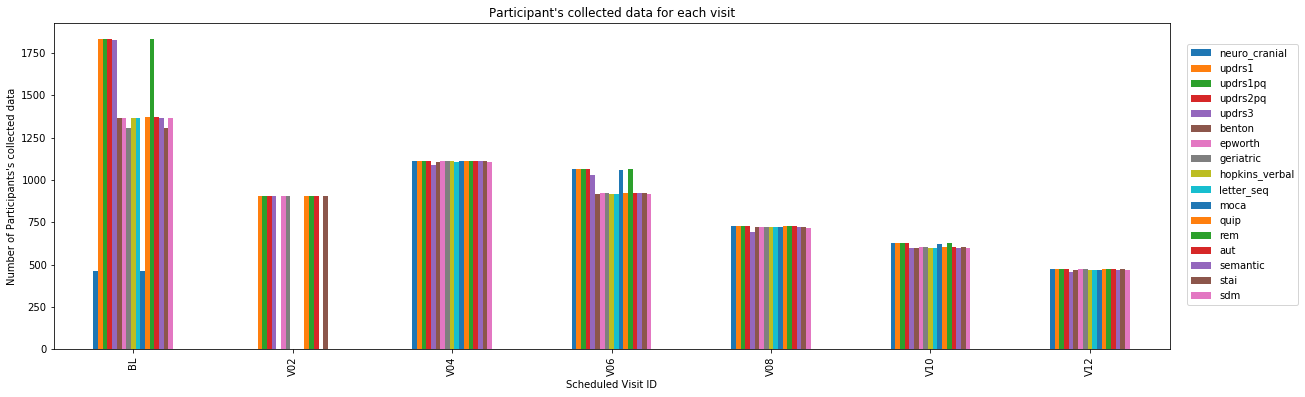

In [279]:
dataset_first_noindx = eval(datasets_of_interest[0])
plot = dataset_first_noindx.groupby('EVENT_ID').size().reset_index().rename(columns={0:datasets_of_interest[0]})

for dataset in datasets_of_interest[1:]:
    dataset_noindx = eval(dataset).reset_index()
    temp_plot = dataset_noindx.groupby('EVENT_ID').size().reset_index().rename(columns={0:dataset})
    
    plot = plot.merge(temp_plot, on='EVENT_ID', how='outer')

plot = plot.set_index('EVENT_ID').loc[visits_of_interest].plot(kind='bar', title="Participant's collected data for each visit", figsize=(20, 6))
plot.legend(bbox_to_anchor=(1.12, 0.95))
plot.set_ylabel("Number of Participants's collected data");
plot.set_xlabel("Scheduled Visit ID");

Dentre os dados obtidos temos a frequência de cada classe

Text(0.5, 0, 'Category')

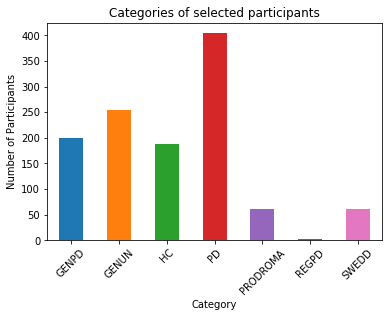

In [280]:
plt.figure(1, figsize=(6, 4))
plot = data_visits["info"].ENROLL_CAT.reset_index().groupby("ENROLL_CAT").size().plot(kind='bar', title="Categories of selected participants", rot=45)
plot.set_ylabel("Number of Participants")
plot.set_xlabel("Category")

## Normalização

Na sequência temos a normalização dos valores utilizando o método Min-Max.

In [281]:
t1 = data_visits['updrs1'].drop('INFODT',axis=1).set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO').unstack().reset_index().set_index('PATNO').interpolate(method='linear', axis=1)
t2 = data_visits['updrs1pq'].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO').unstack().reset_index().set_index('PATNO').interpolate(method='linear', axis=1)
t3 = data_visits['updrs2pq'].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO').unstack().reset_index().set_index('PATNO').interpolate(method='linear', axis=1)
t4 = data_visits['updrs3'].drop(['PAG_NAME','CMEDTM','EXAMTM','PD_MED_USE','ON_OFF_DOSE','ANNUAL_TIME_BTW_DOSE_NUPDRS'],axis=1).set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO').unstack().reset_index().set_index('PATNO').interpolate(method='linear', axis=1)
t5 = data_visits['epworth'].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO').unstack().reset_index().set_index('PATNO').interpolate(method='linear', axis=1)
t6 = data_visits['moca'].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO').unstack().reset_index().set_index('PATNO').interpolate(method='linear', axis=1)
t7 = data_visits['benton'].drop_duplicates(['PATNO','EVENT_ID'], keep='first').set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO').unstack().reset_index().set_index('PATNO').interpolate(method='linear', axis=1)
t8 = data_visits['neuro_cranial'][data_visits['neuro_cranial'].EVENT_ID != 'V03' ].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO').unstack().reset_index().set_index('PATNO').interpolate(method='linear', axis=1)
t9 = data_visits['geriatric'].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO').unstack().reset_index().set_index('PATNO').interpolate(method='linear', axis=1, limit=10, limit_direction='both')
t10 = data_visits['hopkins_verbal'][data_visits['hopkins_verbal'].EVENT_ID != 'V03' ].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO').unstack().reset_index().set_index('PATNO').interpolate(method='linear', axis=1, limit=10, limit_direction='both')
t11 = data_visits['letter_seq'][data_visits['letter_seq'].EVENT_ID != 'V03' ].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO').unstack().reset_index().set_index('PATNO').interpolate(method='linear', axis=1, limit=10, limit_direction='both')
t12 = data_visits['quip'][data_visits['quip'].EVENT_ID != 'V03' ].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO').unstack().reset_index().set_index('PATNO').interpolate(method='linear', axis=1, limit=10, limit_direction='both')
t13 = data_visits['rem'][data_visits['rem'].EVENT_ID != 'V03' ].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO').unstack().reset_index().set_index('PATNO').interpolate(method='linear', axis=1, limit=10, limit_direction='both')
t14 = data_visits['aut'][data_visits['aut'].EVENT_ID != 'V03' ].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO').unstack().reset_index().set_index('PATNO').interpolate(method='linear', axis=1, limit=10, limit_direction='both')
t15 = data_visits['semantic'][data_visits['semantic'].EVENT_ID != 'V03' ].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO').unstack().reset_index().set_index('PATNO').interpolate(method='linear', axis=1, limit=10, limit_direction='both')
t16 = data_visits['stai'][data_visits['stai'].EVENT_ID != 'V03' ].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO').unstack().reset_index().set_index('PATNO').interpolate(method='linear', axis=1, limit=10, limit_direction='both')
t17 = data_visits['sdm'][data_visits['sdm'].EVENT_ID != 'V03' ].set_index(['PATNO','EVENT_ID']).sort_index(level='PATNO').unstack().reset_index().set_index('PATNO').interpolate(method='linear', axis=1, limit=10, limit_direction='both')

data_visits_minmax = {}
for i in range(1, len(datasets_of_interest) + 1):
    dataset = 't' + str(i)
    dataset_columns = eval(dataset).columns.levels[0][0:-1]
    
    data_visits_minmax[dataset] = pd.DataFrame(index=eval(dataset).index, columns=eval(dataset).columns)
    
    for col in dataset_columns:
        data_visits_minmax[dataset][col] = (eval(dataset)[col] - eval(dataset)[col].min().min()) / (eval(dataset)[col].max().max() - eval(dataset)[col].min().min() )

data_visits_minmax['t17'].min()

M_minmax = pd.concat([data_visits_minmax['t1'], data_visits_minmax['t2'], data_visits_minmax['t3'], data_visits_minmax['t4'], 
                  data_visits_minmax['t5'], data_visits_minmax['t6'] , data_visits_minmax['t7'], data_visits_minmax['t8'], 
                  data_visits_minmax['t9'], data_visits_minmax['t10'], data_visits_minmax['t11'], data_visits_minmax['t12'], 
                  data_visits_minmax['t13'], data_visits_minmax['t14'], data_visits_minmax['t15'],data_visits_minmax['t16'],
                  data_visits_minmax['t17']], axis=1).interpolate(method='linear', axis=1, limit=10, limit_direction='both')

## Redução de dimensionalidade

In [282]:
M_chosen = M_minmax
M_chosen = M_chosen.dropna()
M_cat = pd.concat([M_chosen, data_visits["info"].ENROLL_CAT], axis=1)
M_W_columns = ['PCA_1', 'PCA_2', 'PCA_3', 'NMF_2_1', 'NMF_2_2', 'NMF_3_1', 'NMF_3_2', 'NMF_3_3']
M_W = pd.DataFrame(index=M_chosen.index, columns=M_W_columns)

model_pca = PCA(n_components=3)
M_W[['PCA_1', 'PCA_2', 'PCA_3']] = model_pca.fit_transform(M_chosen)

model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(M_chosen)
M_W[['NMF_3_1', 'NMF_3_2', 'NMF_3_3']] = model_NMF3.fit_transform(M_chosen)

Redução para 2 dimensões

Text(0.5, 1.0, 'Dimension reduction with NMF')

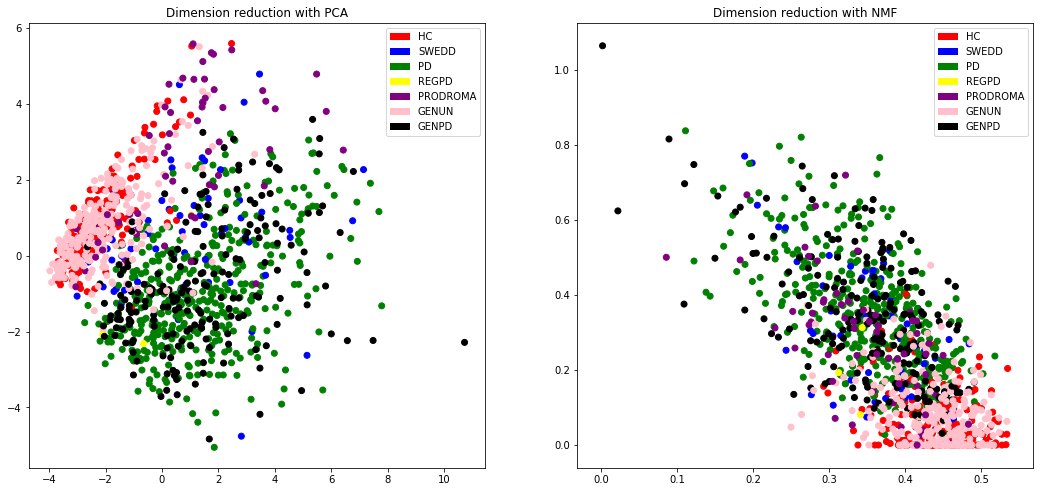

In [283]:
plt.figure(1, figsize=(18, 18))

colors_categories = data_visits["info"].ENROLL_CAT.replace(['HC', 'SWEDD', 'PD', 'REGPD', 'PRODROMA', 'GENUN', 'GENPD'], ['red', 'blue', 'green', 'yellow', 'purple', 'pink', 'black'])

p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='yellow')
p5 = plt.Rectangle((0, 0), 0.1, 0.1, fc='purple')
p6 = plt.Rectangle((0, 0), 0.1, 0.1, fc='pink')
p7 = plt.Rectangle((0, 0), 0.1, 0.1, fc='black')

plt.subplot(2,2,1)
plot_1 = plt.scatter(M_W[['PCA_1']], M_W[['PCA_2']], c = colors_categories)
plt.legend((p1, p2, p3, p4, p5, p6, p7), ('HC', 'SWEDD', 'PD', 'REGPD', 'PRODROMA', 'GENUN', 'GENPD'), loc='best');
plt.title('Dimension reduction with PCA')

plt.subplot(2,2,2)
plot_1 = plt.scatter(M_W[['NMF_2_1']], M_W[['NMF_2_2']], c = colors_categories)
plt.legend((p1, p2, p3, p4, p5, p6, p7), ('HC', 'SWEDD', 'PD', 'REGPD', 'PRODROMA', 'GENUN', 'GENPD'), loc='best');
plt.title('Dimension reduction with NMF')

Redução para 3 dimensões

Text(0.5, 0.92, 'Dimension reduction with NMF')

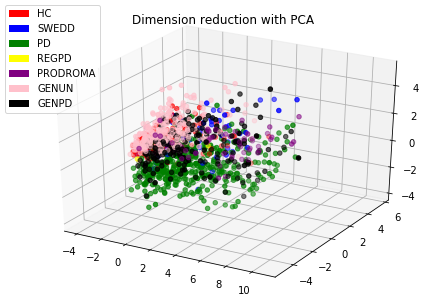

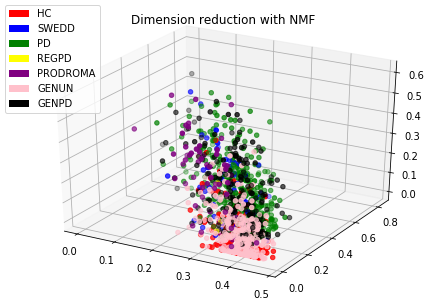

In [284]:
colors_categories = data_visits["info"].ENROLL_CAT.replace(['HC', 'SWEDD', 'PD', 'REGPD', 'PRODROMA', 'GENUN', 'GENPD'], ['red', 'blue', 'green', 'yellow', 'purple', 'pink', 'black'])

p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='yellow')
p5 = plt.Rectangle((0, 0), 0.1, 0.1, fc='purple')
p6 = plt.Rectangle((0, 0), 0.1, 0.1, fc='pink')
p7 = plt.Rectangle((0, 0), 0.1, 0.1, fc='black')

fig = plt.figure()
ax = Axes3D(fig)

plot_1 = ax.scatter(M_W[['PCA_1']], M_W[['PCA_2']], M_W[['PCA_3']], c = colors_categories)
fig.legend((p1, p2, p3, p4, p5, p6, p7), ('HC', 'SWEDD', 'PD', 'REGPD', 'PRODROMA', 'GENUN', 'GENPD'), loc='upper left');
plt.title('Dimension reduction with PCA')

fig = plt.figure()
ax = Axes3D(fig)

plot_2 = ax.scatter(M_W[['NMF_3_1']], M_W[['NMF_3_2']], M_W[['NMF_3_3']], c = colors_categories)
fig.legend((p1, p2, p3, p4, p5, p6, p7), ('HC', 'SWEDD', 'PD', 'REGPD', 'PRODROMA', 'GENUN', 'GENPD'), loc='upper left');
plt.title('Dimension reduction with NMF')

## Classificação não supervisionada

Classificação dos níveis de Parkinson para análise da progressão da doença para os dados reduzidos pelo NMF.

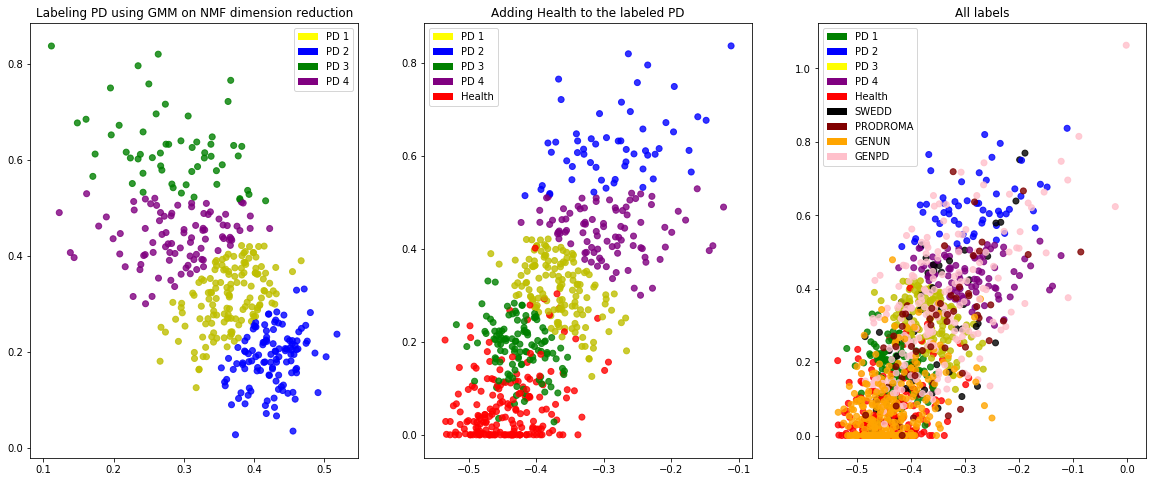

In [285]:
M_label_columns = ['GMM']
M_label = pd.DataFrame(index=M_chosen.index, columns=M_label_columns)

M_label[ M_cat.ENROLL_CAT == "HC" ] = 'HC'
M_label[ M_cat.ENROLL_CAT == "SWEDD" ] = 'SWEDD'
M_label[ M_cat.ENROLL_CAT == "REGPD" ] = 'REGPD'
M_label[ M_cat.ENROLL_CAT == "PRODROMA" ] = 'PRODROMA'
M_label[ M_cat.ENROLL_CAT == "GENUN" ] = 'GENUN'
M_label[ M_cat.ENROLL_CAT == "GENPD" ] = 'GENPD'

M_gmm_chosen = M_W[['NMF_2_1', 'NMF_2_2']]
M_PD_gmm_chosen = M_gmm_chosen[ M_cat.ENROLL_CAT == "PD" ]
M_PD_HC_gmm_chosen = M_gmm_chosen[ M_cat.ENROLL_CAT.isin(['HC', 'PD']) ]
M_PD_HC_SWEDD_gmm_chosen = M_gmm_chosen[ M_cat.ENROLL_CAT.isin(['HC', 'PD', 'SWEDD']) ]
M_ALL_chosen = M_gmm_chosen[ M_cat.ENROLL_CAT.isin(['HC', 'SWEDD', 'PD', 'PRODROMA', 'GENUN', 'GENPD']) ]

model_gmm = mixture.GaussianMixture(n_components=4)
model_gmm.fit(M_PD_gmm_chosen)

M_label.loc[ M_cat.ENROLL_CAT == "PD", 'GMM' ] = model_gmm.predict(M_PD_gmm_chosen)
M_label.replace([0,1,2,3],['PD 1', 'PD 2', 'PD 3', 'PD 4'], inplace=True)
M_label_PD = M_label[ M_cat.ENROLL_CAT.isin(['PD']) ]
M_label_PD_HC = M_label[ M_cat.ENROLL_CAT.isin(['HC', 'PD']) ]
M_label_PD_HC_SWEDD = M_label[ M_cat.ENROLL_CAT.isin(['HC', 'PD', 'SWEDD']) ]
M_label_ALL = M_label[ M_cat.ENROLL_CAT.isin(['HC', 'SWEDD', 'PD', 'PRODROMA', 'GENUN', 'GENPD']) ]

p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='yellow')
p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='purple')
p5 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
p7 = plt.Rectangle((0, 0), 0.1, 0.1, fc='maroon')
p8 = plt.Rectangle((0, 0), 0.1, 0.1, fc='black')
p9 = plt.Rectangle((0, 0), 0.1, 0.1, fc='pink')
p10 = plt.Rectangle((0, 0), 0.1, 0.1, fc='orange')

plt.figure(1, figsize=(20, 8))
plt.subplot(1,3,1)
colors = ['b' if i==0 else 'g' if i==1 else 'y' if i==2 else 'purple' if i==3 else 'r' for i in model_gmm.predict(M_PD_gmm_chosen)]
ax = plt.scatter(M_PD_gmm_chosen['NMF_2_1'], M_PD_gmm_chosen['NMF_2_2'], c=colors, alpha=0.8)
plt.legend((p1, p2, p3, p4), ('PD 1', 'PD 2', 'PD 3', 'PD 4'), loc='best');
plt.title('Labeling PD using GMM on NMF dimension reduction')

plt.subplot(1,3,2)
colors = ['r' if i=='HC' else 'g' if i=='PD 1' else 'b' if i=='PD 2' else 'y' if i=='PD 3' else 'purple' if i=='PD 4' else 'black' for i in M_label_PD_HC['GMM']]
ax = plt.scatter(-M_PD_HC_gmm_chosen['NMF_2_1'], M_PD_HC_gmm_chosen['NMF_2_2'], c=colors, alpha=0.8)
plt.legend((p1, p2, p3, p4, p5), ('PD 1', 'PD 2', 'PD 3', 'PD 4', 'Health'), loc='best');
plt.title('Adding Health to the labeled PD')

plt.subplot(1,3,3)
colors = ['r' if i=='HC'
          else 'g' if i=='PD 1'
          else 'b' if i=='PD 2'
          else 'y' if i=='PD 3'
          else 'black' if i=='SWEDD'
          else 'purple' if i=='PD 4'
          else 'maroon' if i=='PRODROMA'
          else 'orange' if i=='GENUN'
          else 'pink' for i in M_label_ALL['GMM']]
ax = plt.gca()
ax.scatter(-M_ALL_chosen['NMF_2_1'], M_ALL_chosen['NMF_2_2'], c=colors, alpha=0.8)
plt.legend((p3, p2, p1, p4, p5, p8, p7, p10, p9), ('PD 1', 'PD 2', 'PD 3', 'PD 4', 'Health', 'SWEDD', 'PRODROMA', 'GENUN', 'GENPD'), loc='best');
plt.title('All labels')
plt.show()

## Comparação de classificadores

Classificação dos níveis de Parkinson para análise da progressão da doença para os diferentes conjuntos de dados para comparação dos classificadores.

/home/fmalaguth/Documents/Git/ppmi-studies/python/venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fmalaguth/Documents/Git/ppmi-studies/python/venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/fmalaguth/Documents/Git/ppmi-studies/python/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


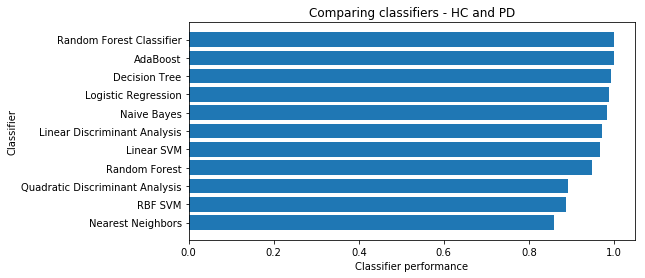

/home/fmalaguth/Documents/Git/ppmi-studies/python/venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/fmalaguth/Documents/Git/ppmi-studies/python/venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/fmalaguth/Documents/Git/ppmi-studies/python/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/fmalaguth/Documents/Git/ppmi-studies/python/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


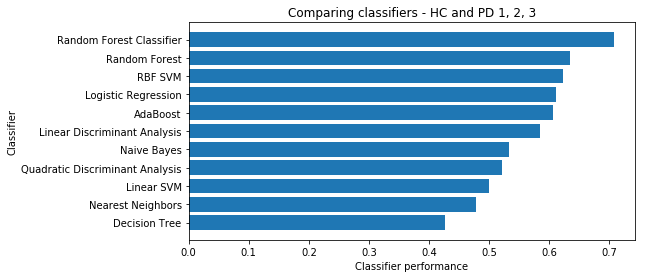

/home/fmalaguth/Documents/Git/ppmi-studies/python/venv/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/fmalaguth/Documents/Git/ppmi-studies/python/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/fmalaguth/Documents/Git/ppmi-studies/python/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


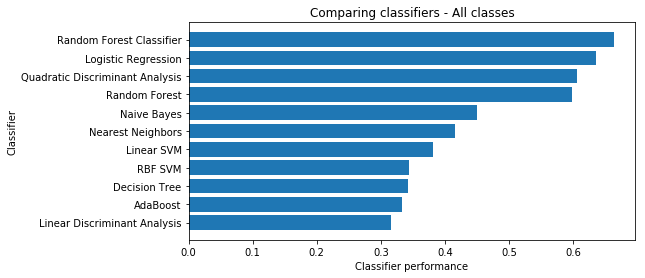

In [286]:
h = .02
names = \
[
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
    "Linear Discriminant Analysis",
    "Quadratic Discriminant Analysis",
    "Logistic Regression",
    "Random Forest Classifier"
]

classifiers = \
[
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=0.8, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(),
    RandomForestClassifier(n_estimators = 40)
]

X_ALL    = M_chosen.loc[M_label_ALL.index, M_chosen.columns.get_level_values(1)=='BL'].stack().reset_index().set_index('PATNO').drop('EVENT_ID',1)
Y_ALL    = M_label_ALL.GMM.replace(['HC', 'PD 1', 'PD 2', 'PD 3', 'PD 4', 'SWEDD', 'PRODROMA', 'GENUN', 'GENPD'], ['0', '1', '2', '3', '4', '5', '6', '7', '8'])
X_PD_H   = M_chosen.loc[M_label_PD_HC.index, M_chosen.columns.get_level_values(1)=='BL'].stack().reset_index().set_index('PATNO').drop('EVENT_ID',1)
Y_PD_H   = M_label_PD_HC.GMM.replace(['HC', 'PD 1', 'PD 2', 'PD 3', 'PD 4'], ['0', '1', '2', '3', '4'])
X_simple = M_chosen.loc[M_label_PD_HC.index, M_chosen.columns.get_level_values(1)=='BL'].stack().reset_index().set_index('PATNO').drop('EVENT_ID',1)
Y_simple = M_label_PD_HC.GMM.replace(['HC', 'PD 1', 'PD 2', 'PD 3', 'PD 4'], ['0', '1', '1', '1', '1'])

X_train, X_test, Y_train, Y_test = train_test_split(X_ALL, Y_ALL, test_size=0.3, random_state=42)
X_PD_H_train, X_PD_H_test, Y_PD_H_train, Y_PD_H_test = train_test_split(X_PD_H, Y_PD_H, test_size=0.3, random_state=42)
X_simple_train, X_simple_test, Y_simple_train, Y_simple_test = train_test_split(X_simple, Y_simple, test_size=0.3, random_state=42)

scores = []
for name, clf in zip(names, classifiers):
    clf.fit(X_simple_train, Y_simple_train)
    score = clf.score(X_simple_test, Y_simple_test)
    scores.append(score)

plt.figure(1, figsize=(8, 4))
imp, names = zip(*sorted(zip(scores, names)))
plt.barh(range(len(names)), imp, align = 'center')
plt.yticks(range(len(names)), names)
plt.xlabel('Classifier performance')
plt.ylabel('Classifier')
plt.title('Comparing classifiers - HC and PD')
plt.show()

scores = []
for name, clf in zip(names, classifiers):
    clf.fit(X_PD_H_train, Y_PD_H_train)
    score = clf.score(X_PD_H_test, Y_PD_H_test)
    scores.append(score)

plt.figure(1, figsize=(8, 4))
imp, names = zip(*sorted(zip(scores, names)))
plt.barh(range(len(names)), imp, align = 'center')
plt.yticks(range(len(names)), names)
plt.xlabel('Classifier performance')
plt.ylabel('Classifier')
plt.title('Comparing classifiers - HC and PD 1, 2, 3')
plt.show()

scores = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, Y_train)
    score = clf.score(X_test, Y_test)
    scores.append(score)

plt.figure(1, figsize=(8, 4))
imp, names = zip(*sorted(zip(scores, names)))
plt.barh(range(len(names)), imp, align = 'center')
plt.yticks(range(len(names)), names)
plt.xlabel('Classifier performance')
plt.ylabel('Classifier')
plt.title('Comparing classifiers - All classes')
plt.show()

## Shap

Influência dos indicadores no classificador Random Forest.

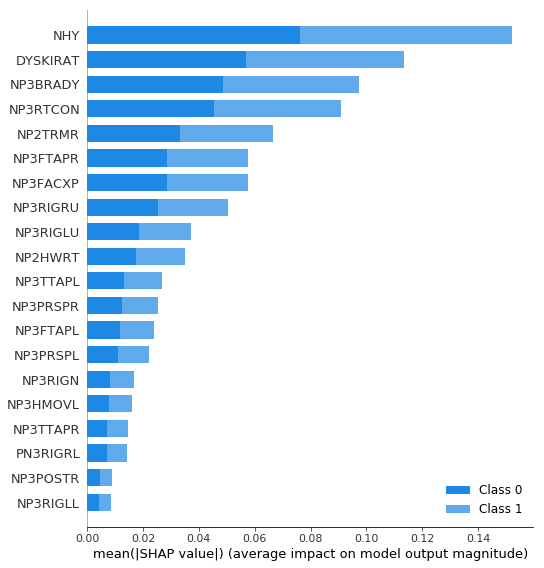

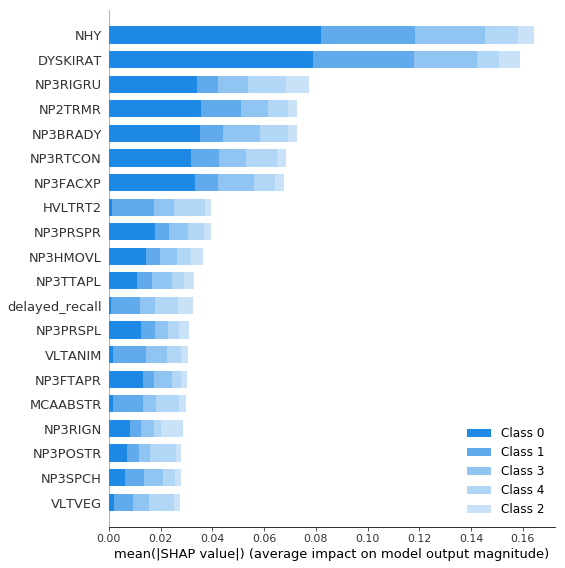

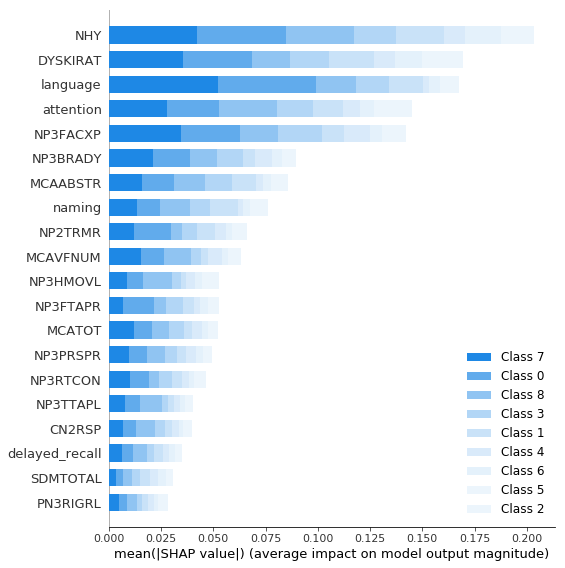

In [287]:
rf = RandomForestClassifier(n_estimators = 40)

rf.fit(X_simple_train, Y_simple_train)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_simple_test)
shap.summary_plot(shap_values, X_simple_train, feature_names=X_simple_train.columns)

rf.fit(X_PD_H_train, Y_PD_H_train)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_PD_H_test)
shap.summary_plot(shap_values, X_PD_H_train, feature_names=X_PD_H_train.columns)

rf.fit(X_train, Y_train)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

## ROC

ROC das diferentes classes para o classificador Random Forest.

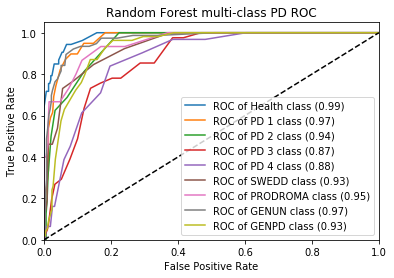

In [288]:
n_classes = len(Y_test.unique())
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    preds = rf.predict_proba(X_test)[:,i]
    label = [1 if int(j) == (i) else 0 for j in Y_test]
    fpr[i], tpr[i], _ = metrics.roc_curve(label, preds)
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    class_name = 'Health' if i==0 else 'PD 1' if i==1 else 'PD 2' if i==2 else 'PD 3' if i==3 else 'PD 4' if i==4 else 'SWEDD' if i==5 else 'PRODROMA' if i==6 else 'GENUN' if i==7 else 'GENPD' if i==8 else 'NA'
    plt.plot(fpr[i], tpr[i], label='ROC of {0} class ({1:0.2f})'
                                   ''.format(class_name, roc_auc[i]))

plt.figure(1, figsize=(8, 4))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest multi-class PD ROC')
plt.legend(loc="lower right")
plt.show()

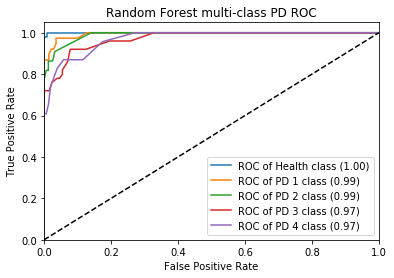

In [289]:
n_classes = len(Y_PD_H_test.unique())
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    preds = rf.predict_proba(X_PD_H_test)[:,i]
    label = [1 if int(j) == (i) else 0 for j in Y_PD_H_test]
    fpr[i], tpr[i], _ = metrics.roc_curve(label, preds)
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    class_name = 'Health' if i==0 else 'PD 1' if i==1 else 'PD 2' if i==2 else 'PD 3' if i==3 else 'PD 4' if i==4 else 'NA'
    plt.plot(fpr[i], tpr[i], label='ROC of {0} class ({1:0.2f})'
                                   ''.format(class_name, roc_auc[i]))

plt.figure(1, figsize=(8, 4))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest multi-class PD ROC')
plt.legend(loc="lower right")
plt.show()

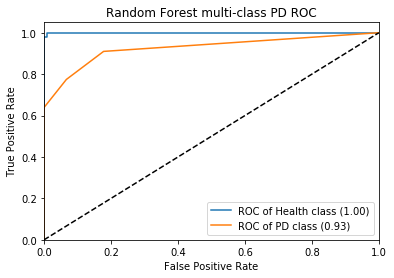

In [290]:
n_classes = len(Y_simple_test.unique())
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    preds = rf.predict_proba(X_simple_test)[:,i]
    label = [1 if int(j) == (i) else 0 for j in Y_simple_test]
    fpr[i], tpr[i], _ = metrics.roc_curve(label, preds)
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    class_name = 'Health' if i==0 else 'PD' if i==1 else 'NA'
    plt.plot(fpr[i], tpr[i], label='ROC of {0} class ({1:0.2f})'
                                   ''.format(class_name, roc_auc[i]))

plt.figure(1, figsize=(8, 4))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest multi-class PD ROC')
plt.legend(loc="lower right")
plt.show()